In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import os
from tqdm import tqdm

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

In [4]:
PATH = Path('../data/')

In [5]:
! ls {PATH}

annotations  download.sh  images


In [6]:
path_anno = PATH/'annotations'
path_img = PATH/'images'

In [7]:
np.random.seed(96)
pattern = r'/([^/]+)_\d+.jpg$'

In [8]:
fnames = get_image_files(path_img)
print(fnames[:5])

[PosixPath('../data/images/leonberger_44.jpg'), PosixPath('../data/images/german_shorthaired_140.jpg'), PosixPath('../data/images/Persian_66.jpg'), PosixPath('../data/images/chihuahua_81.jpg'), PosixPath('../data/images/Persian_121.jpg')]


In [9]:
size=224
bs=64
data = ImageDataBunch.from_name_re(path_img, 
                                   fnames, 
                                   pattern, 
                                   ds_tfms=get_transforms(), 
                                   size=size, bs=bs).normalize(imagenet_stats)

In [11]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [12]:
learn.model


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [15]:
from torchsummary import summary
summary(learn.model, (3, size, size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


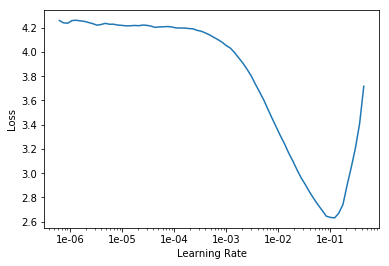

In [17]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(4, max_lr=0.01)

epoch,train_loss,valid_loss,error_rate
1,0.932842,0.643636,0.204330
2,0.796155,0.671708,0.207037
3,0.496459,0.248108,0.074425
4,0.306746,0.205165,0.064276


In [20]:
learn.save('stage-1')

Initial train is done. Let's see some of the worst preditions.

In [21]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(data, preds, y, losses)

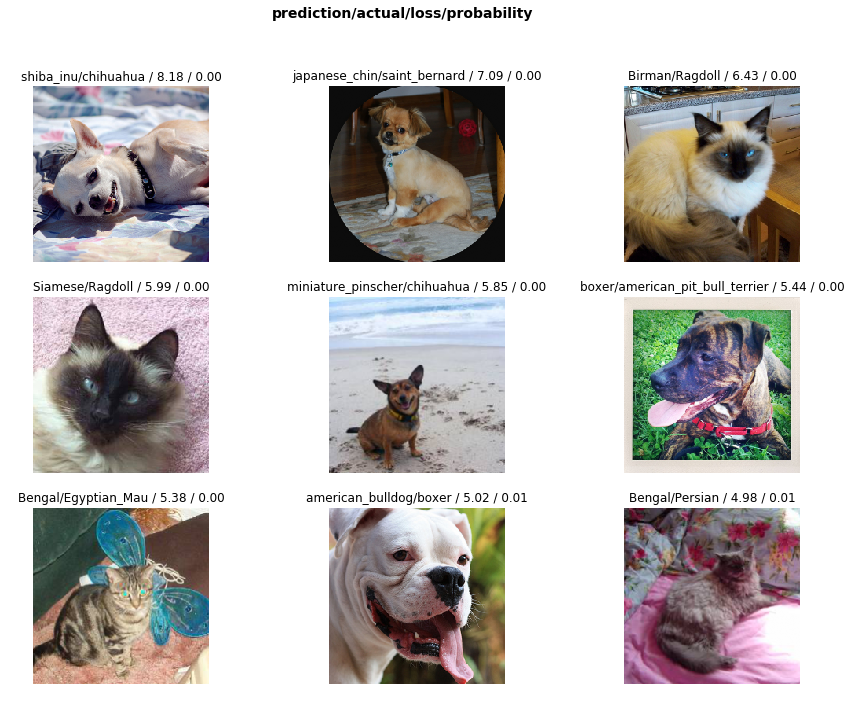

In [23]:
interp.plot_top_losses(9, figsize=(15,11))

In [24]:
interp.most_confused(min_val=2)

[('Ragdoll', 'Birman', 9),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 5),
 ('boxer', 'american_bulldog', 5),
 ('Bengal', 'Egyptian_Mau', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('beagle', 'basset_hound', 3)]

Fine tune the backbone as well:

In [27]:
learn.load('stage-1');

In [28]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


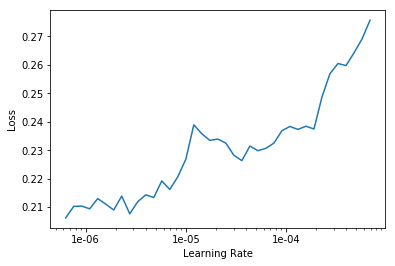

In [29]:
learn.recorder.plot()

In [30]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-7,1e-5))

epoch,train_loss,valid_loss,error_rate
1,0.246976,0.202669,0.063599
2,0.233907,0.201151,0.062246


Save the model for deployment.

In [31]:
learn.export()